# NBA Offense: Why is it Soaring?

The offense of the modern NBA is a point of discussion among many fans. The crux of the argument revolves around how much better offenses are than they used to be. Many fans will say that the players are simply more skilled, and those higher skills combined with optimization of play have taken offense to heights it hasn't seen before. Using FiveThirtyEight's data on player efficiency, I'm here to provide some reasons why offense has exploded.

It's worth pointing out that I can only answer from a statistical perspective. Another common argument that people use is that there have been rule changes that benefit offenses. Sadly this is beyond our scope here.

In [52]:
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency

import pandas as pd
import numpy as np
import seaborn as sns

In [53]:
pleff = pd.read_csv('nba-data-historical.csv', encoding='utf-8')

'pleff' represents player efficiency data from 1977 to 2019.

In [54]:
pleff.head()

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,...,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
0,youngtr01,Trae Young,2020,RS,21,ATL,PG,NaN,ATL,60,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,45.5,44.8,2.9
1,huntede01,De'Andre Hunter,2020,RS,22,ATL,SF,NaN,ATL,63,...,0.7,NaN,NaN,NaN,NaN,NaN,NaN,44.5,21.1,0.0
2,huertke01,Kevin Huerter,2020,RS,21,ATL,SG,NaN,ATL,56,...,1.3,NaN,NaN,NaN,NaN,NaN,NaN,54.8,10.5,0.1
3,reddica01,Cam Reddish,2020,RS,20,ATL,SF,NaN,ATL,58,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,45.1,22.7,0.9
4,collijo01,John Collins,2020,RS,22,ATL,PF,NaN,ATL,41,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,24.3,24.8,0.1


The first objective in answering this question is identifying what metrics we want to use to measure skill and efficiency from both an offensive and defensive perspective, as well as what specific questions will lead us in the best direction.

Offense - Assist%, TS%, ORtg

Defense - Steal%, Def. Reb%, DRtg


To briefly explain these stats:

-Offensive Rating: An estimate of how many points a player produces per 100 possessions while he is on the floor.

-Defensive Rating: Points allowed per 100 possessions by a player's team while he is on the floor.

-Assist% (Assist Percentage): Percentage of a player's team's field goals that he assisted on while he was on the floor. (Note: A player is awarded an assist when he makes a pass to another player and then that player makes a field goal directly after)

-Steal% (Steal Percentage): Percentage of *opposing team's* possessions that ended with a player recording a steal while he was on the floor. (Note: A player is awarded with a steal when he "legally takes the ball away from an opponent, intercepts a pass, or otherwise obtains possession on the ball following an opponent's turnover" (NBA definition))

-DRB% (Defensive Rebound Percentage): Percentage of available defensive rebounds that a player grabbed while he was on the floor. (Note: A rebound is awarded when a player takes possession of the ball following a *missed shot*. A rebound is defensive if the missed shot was from the opposing team.)

-TS% (True Shooting %): A measure of a player's shooting percentage, but adjusted to properly weight two-point shots, three-point shots, and free throws. It provides a nice all-in-one statistic for how efficient a player is at scoring.

**(TS% = Points / (2 * (Field Goal Attempts + 0.44 * Free Throw Attempts))**

## Cutting down our data

This dataset is a bit too inclusive for our purposes at the moment - it includes every player no matter how important they were to their team. So we need to trim it down a bit. We will do this by creating a new set that only includes the players that played at least 20 minutes per game. This is a reasonable benchmark for a player that is, at the very least, important to his team.

This will also do another job for us - it will also filter out all rows where 'type' is set to 'PO'. This will make sure we are only including regular season stats. Since the regular season is longer, that ensures we have our best possible sample size for each player-season.

One final note before we get into things: I use the terms "year" and season" interchangeably. For clarification, the NBA season runs from October to April, so when we say the 2019 "season" (reflected as year_id in the dataset), what I really mean is the season that ran from October 2018 to April 2019.

In [55]:
pleff_20_min = pleff[pleff['MPG'] >= 20]

In [56]:
pleff_20_min.head()

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,...,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
0,youngtr01,Trae Young,2020,RS,21,ATL,PG,NaN,ATL,60,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,45.5,44.8,2.9
1,huntede01,De'Andre Hunter,2020,RS,22,ATL,SF,NaN,ATL,63,...,0.7,NaN,NaN,NaN,NaN,NaN,NaN,44.5,21.1,0.0
2,huertke01,Kevin Huerter,2020,RS,21,ATL,SG,NaN,ATL,56,...,1.3,NaN,NaN,NaN,NaN,NaN,NaN,54.8,10.5,0.1
3,reddica01,Cam Reddish,2020,RS,20,ATL,SF,NaN,ATL,58,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,45.1,22.7,0.9
4,collijo01,John Collins,2020,RS,22,ATL,PF,NaN,ATL,41,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,24.3,24.8,0.1


Going through every single season would be laborious and unnecessary. So we will consider data from 1979, 1989, 1999, 2009, and 2019. Our first order of business is to create five new datasets, each one containing the data from one particular season. This will allow us to view long term trends over all else.

One may ask why I'm taking snapshots of different time periods instead of aggregating all the data into blocks - this is because due to the (sometimes extreme) differences in play style between eras, it would be basically impossible to both get relatively equal amounts of data for each block while still keeping each era of basketball separate.

In [57]:
pleff_79 = pleff_20_min[pleff_20_min['year_id'] == 1979]
pleff_89 = pleff_20_min[pleff_20_min['year_id'] == 1989]
pleff_99 = pleff_20_min[pleff_20_min['year_id'] == 1999]
pleff_09 = pleff_20_min[pleff_20_min['year_id'] == 2009]
pleff_19 = pleff_20_min[pleff_20_min['year_id'] == 2019]

In [58]:
pleff_79

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,...,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
26820,roundda01,Dan Roundfield,1979,RS,25,ATL,PF,2.0,ATL,80,...,4.0,109.6,20.6,99.2,50.4,0.0,71.4,0.0,45.9,0.1
26821,hillar01,Armond Hill,1979,RS,25,ATL,PG,2.0,ATL,82,...,0.4,104.7,16.8,106.4,43.4,0.0,85.4,0.0,42.2,0.2
26822,johnsed02,Eddie Johnson,1979,RS,23,ATL,SG,2.0,ATL,78,...,0.3,109.2,21.6,105.8,51.0,0.0,83.2,0.0,29.7,0.2
26823,drewjo01,John Drew,1979,RS,24,ATL,SF,2.0,ATL,79,...,0.4,109.4,29.1,102.8,47.3,0.0,73.1,0.0,49.2,0.7
26824,hawesst01,Steve Hawes,1979,RS,28,ATL,PF,2.0,ATL,81,...,1.2,106.7,17.3,102.0,49.2,0.0,81.8,0.0,17.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27249,dandrbo01,Bob Dandridge,1979,PO,31,WSB,SF,NaN,WAS,19,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,29.9,-0.4
27250,hayesel01,Elvin Hayes,1979,PO,33,WSB,PF,NaN,WAS,19,...,3.4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,32.8,-0.4
27251,unselwe01,Wes Unseld,1979,PO,32,WSB,C,NaN,WAS,19,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,40.5,-0.6
27252,hendeto01,Tom Henderson,1979,PO,27,WSB,PG,NaN,WAS,19,...,0.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,29.7,-0.3


In [59]:
pleff_89

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,...,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
21662,wilkido01,Dominique Wilkins,1989,RS,29,ATL,SF,5.0,ATL,80,...,1.0,114.3,27.6,108.5,47.5,27.6,84.4,6.0,29.8,-0.7
21663,malonmo01,Moses Malone,1989,RS,33,ATL,C,5.0,ATL,81,...,2.1,116.0,23.5,105.2,49.6,0.0,78.9,1.1,64.9,-0.9
21664,theusre01,Reggie Theus,1989,RS,31,ATL,SG,5.0,ATL,82,...,0.4,110.6,22.6,109.8,47.6,29.3,85.1,5.4,31.4,0.0
21665,riverdo01,Doc Rivers,1989,RS,27,ATL,PG,5.0,ATL,76,...,1.0,118.0,19.3,105.6,47.4,34.7,86.1,15.2,35.2,0.2
21666,levincl01,Cliff Levingston,1989,RS,28,ATL,PF,5.0,ATL,80,...,1.9,113.5,14.2,105.7,53.1,20.0,69.6,0.9,33.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22229,kingbe01,Bernard King,1989,RS,32,WSB,SF,-2.1,WAS,81,...,0.3,106.9,27.3,111.0,48.4,16.7,81.9,2.2,32.2,-0.2
22230,malonje01,Jeff Malone,1989,RS,27,WSB,SG,-2.1,WAS,76,...,0.3,107.4,26.7,113.4,48.6,5.3,87.1,1.3,24.1,-0.4
22231,willijo02,John Williams,1989,RS,22,WSB,SF,-2.1,WAS,82,...,1.7,110.1,20.9,104.2,48.2,26.8,77.6,7.6,30.9,-0.1
22232,catlete01,Terry Catledge,1989,RS,25,WSB,PF,-2.1,WAS,79,...,0.7,105.5,17.8,108.7,49.3,20.0,60.2,0.7,37.3,0.1


In [60]:
pleff_99

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,...,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
15266,mutomdi01,Dikembe Mutombo,1999,RS,32,ATL,C,3.4,ATL,50,...,6.0,114.6,15.4,92.3,51.2,0.0,68.4,0.0,84.3,-1.0
15267,blaylmo01,Mookie Blaylock,1999,RS,31,ATL,PG,3.4,ATL,48,...,0.4,100.2,21.9,96.2,42.5,30.7,75.8,38.6,14.0,-0.1
15268,longgr01,Grant Long,1999,RS,32,ATL,PF,3.4,ATL,50,...,0.9,108.4,18.5,95.6,43.4,16.7,78.3,5.0,65.5,0.1
15269,smithst01,Steve Smith,1999,RS,29,ATL,SG,3.4,ATL,36,...,0.6,106.8,25.9,100.3,42.4,33.8,84.9,25.7,41.7,0.0
15270,hendeal01,Alan Henderson,1999,RS,26,ATL,SF,3.4,ATL,38,...,1.2,101.8,21.9,97.3,44.3,0.0,67.1,0.2,35.2,-0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15915,stricro02,Rod Strickland,1999,RS,32,WAS,PG,-2.5,WAS,44,...,0.2,104.2,26.2,103.9,42.6,28.6,74.6,7.0,39.1,-0.6
15916,thorpot01,Otis Thorpe,1999,RS,36,WAS,PF,-2.5,WAS,49,...,0.9,107.5,17.3,103.0,54.8,0.0,69.8,0.5,24.1,0.2
15917,howarju01,Juwan Howard,1999,RS,25,WAS,SF,-2.5,WAS,36,...,0.7,101.1,24.1,103.6,47.6,0.0,75.3,0.5,24.2,-0.3
15918,cheanca01,Calbert Cheaney,1999,RS,27,WAS,SG,-2.5,WAS,50,...,0.9,91.2,16.9,105.4,43.4,21.6,49.3,8.9,16.1,0.4


In [61]:
pleff_09

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,...,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
8390,johnsjo02,Joe Johnson,2009,RS,27,ATL,SG,1.8,ATL,79,...,0.5,109.9,26.5,110.2,46.8,36.0,82.6,29.2,25.5,-0.2
8391,bibbymi01,Mike Bibby,2009,RS,30,ATL,PG,1.8,ATL,79,...,0.3,112.6,20.7,109.4,46.8,39.0,78.9,42.6,17.0,-0.2
8392,smithjo03,Josh Smith,2009,RS,23,ATL,PF,1.8,ATL,69,...,3.5,103.5,22.5,104.4,51.4,29.9,58.8,10.2,42.3,-0.1
8393,horfoal01,Al Horford,2009,RS,22,ATL,C,1.8,ATL,67,...,3.3,114.0,17.0,103.9,52.6,0.0,72.7,0.2,34.5,-0.6
8394,willima02,Marvin Williams,2009,RS,22,ATL,SF,1.8,ATL,61,...,1.4,117.1,17.7,108.0,49.3,35.5,80.6,24.9,43.9,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,crittja01,Javaris Crittenton,2009,RS,21,WAS,PG,-8.2,WAS,56,...,0.4,97.2,16.9,115.0,47.7,14.3,59.3,5.2,30.0,0.0
9096,stevede01,DeShawn Stevenson,2009,RS,27,WAS,SG,-8.2,WAS,32,...,0.2,92.5,15.0,117.3,36.3,27.1,53.3,55.8,26.0,0.1
9099,daniean01,Antonio Daniels,2009,RS,33,WAS,PG,-8.2,WAS,13,...,0.0,114.5,12.8,117.2,38.2,45.5,75.8,24.4,73.3,-0.3
9102,haywobr01,Brendan Haywood,2009,RS,29,WAS,C,-8.2,WAS,6,...,7.0,98.8,18.0,109.0,48.0,0.0,47.6,0.0,42.0,-0.6


In [62]:
pleff_19

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,...,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
808,youngtr01,Trae Young,2019,RS,20,ATL,PG,-5.7,ATL,81,...,0.5,107.4,29.8,116.8,47.7,32.4,82.9,38.4,33.0,1.8
809,huertke01,Kevin Huerter,2019,RS,20,ATL,SG,-5.7,ATL,75,...,1.1,105.5,15.7,116.2,45.7,38.5,73.2,53.7,8.5,0.6
810,bembrde01,DeAndre' Bembry,2019,RS,24,ATL,SG,-5.7,ATL,82,...,1.8,97.2,17.4,111.5,50.8,28.9,64.0,28.1,22.1,0.6
811,collijo01,John Collins,2019,RS,21,ATL,PF,-5.7,ATL,61,...,1.8,121.7,23.3,114.6,60.9,34.8,76.3,19.0,32.0,0.2
812,bazemke01,Kent Bazemore,2019,RS,29,ATL,SG,-5.7,ATL,67,...,2.2,98.1,21.3,111.8,46.5,32.0,72.6,43.4,25.3,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,portibo01,Bobby Portis,2019,RS,23,WAS,PF,-2.8,WAS,28,...,1.3,104.0,22.8,111.7,45.8,40.3,80.9,33.3,13.2,0.4
1626,oubreke01,Kelly Oubre Jr.,2019,RS,23,WAS,SF,-2.8,WAS,29,...,2.2,105.3,19.4,113.4,52.6,31.1,80.0,43.3,27.9,0.6
1629,riverau01,Austin Rivers,2019,RS,26,WAS,SG,-2.8,WAS,29,...,1.2,94.7,15.5,116.5,48.9,31.1,54.3,54.6,23.7,-0.3
1630,parkeja01,Jabari Parker,2019,RS,23,WAS,PF,-2.8,WAS,25,...,2.0,104.7,23.8,111.8,61.3,29.6,68.4,28.4,26.7,1.3


Since we're looking to measure offensive improvement, we will do a few things: 

1) Track increase in rating and our percentage stats from earlier.
2) Find correlation between these ratings and our preferred statistics. This will allow us to see how much change has come due to improvements in single offensive statistics, and how much hasn't - this will provide indication of how much offense has *actually* improved. 

## Sorting

We're going to create new tables for each season - one sorted by each of our preferred statistics. We will then take the top 25 players in each of those statistics. This is because top 25 is often considered a significant barrier in basketball parlance; to be top 25 in something generally means that a player is very good at that particular thing.

We want to measure the best players in each statistic because when considering whether offense or defense has improved or regressed, the average person will implicitly be talking about "the best" offense or "the best" defense. Obviously bad offense and bad defense have always and will always be, well, bad.

In [63]:
pleff_79_off = pleff_79.sort_values(by = 'ORtg', ascending=False)
pleff_79_def = pleff_79.sort_values(by = 'DRtg', ascending=True)
pleff_79_stl = pleff_79.sort_values(by = 'STL%', ascending=False)
pleff_79_drb = pleff_79.sort_values(by = 'DRB%', ascending=False)
pleff_79_ts = pleff_79.sort_values(by = 'TS%', ascending=False)
pleff_79_ast = pleff_79.sort_values(by = 'AST%', ascending=False)


pleff_89_off = pleff_89.sort_values(by = 'ORtg', ascending=False)
pleff_89_def = pleff_89.sort_values(by = 'DRtg', ascending=True)
pleff_89_stl = pleff_89.sort_values(by = 'STL%', ascending=False)
pleff_89_drb = pleff_89.sort_values(by = 'DRB%', ascending=False)
pleff_89_ts = pleff_89.sort_values(by = 'TS%', ascending=False)
pleff_89_ast = pleff_89.sort_values(by = 'AST%', ascending=False)

pleff_99_off = pleff_99.sort_values(by = 'ORtg', ascending=False)
pleff_99_def = pleff_99.sort_values(by = 'DRtg', ascending=True)
pleff_99_stl = pleff_99.sort_values(by = 'STL%', ascending=False)
pleff_99_drb = pleff_99.sort_values(by = 'DRB%', ascending=False)
pleff_99_ts = pleff_99.sort_values(by = 'TS%', ascending=False)
pleff_99_ast = pleff_99.sort_values(by = 'AST%', ascending=False)

pleff_09_off = pleff_09.sort_values(by = 'ORtg', ascending=False)
pleff_09_def = pleff_09.sort_values(by = 'DRtg', ascending=True)
pleff_09_stl = pleff_09.sort_values(by = 'STL%', ascending=False)
pleff_09_drb = pleff_09.sort_values(by = 'DRB%', ascending=False)
pleff_09_ts = pleff_09.sort_values(by = 'TS%', ascending=False)
pleff_09_ast = pleff_09.sort_values(by = 'AST%', ascending=False)

pleff_19_off = pleff_19.sort_values(by = 'ORtg', ascending=False)
pleff_19_def = pleff_19.sort_values(by = 'DRtg', ascending=True)
pleff_19_stl = pleff_19.sort_values(by = 'STL%', ascending=False)
pleff_19_drb = pleff_19.sort_values(by = 'DRB%', ascending=False)
pleff_19_ts = pleff_19.sort_values(by = 'TS%', ascending=False)
pleff_19_ast = pleff_19.sort_values(by = 'AST%', ascending=False)

In [64]:
pleff_79_off_top_25 = pleff_79_off.head(25)
pleff_79_def_top_25 = pleff_79_def.head(25)
pleff_79_stl_top_25 = pleff_79_stl.head(25)
pleff_79_drb_top_25 = pleff_79_drb.head(25)
pleff_79_ts_top_25 = pleff_79_ts.head(25)
pleff_79_ast_top_25 = pleff_79_ast.head(25)

pleff_89_off_top_25 = pleff_89_off.head(25)
pleff_89_def_top_25 = pleff_89_def.head(25)
pleff_89_stl_top_25 = pleff_89_stl.head(25)
pleff_89_drb_top_25 = pleff_89_drb.head(25)
pleff_89_ts_top_25 = pleff_89_ts.head(25)
pleff_89_ast_top_25 = pleff_89_ast.head(25)

pleff_99_off_top_25 = pleff_99_off.head(25)
pleff_99_def_top_25 = pleff_99_def.head(25)
pleff_99_stl_top_25 = pleff_99_stl.head(25)
pleff_99_drb_top_25 = pleff_99_drb.head(25)
pleff_99_ts_top_25 = pleff_99_ts.head(25)
pleff_99_ast_top_25 = pleff_99_ast.head(25)

pleff_09_off_top_25 = pleff_09_off.head(25)
pleff_09_def_top_25 = pleff_09_def.head(25)
pleff_09_stl_top_25 = pleff_09_stl.head(25)
pleff_09_drb_top_25 = pleff_09_drb.head(25)
pleff_09_ts_top_25 = pleff_09_ts.head(25)
pleff_09_ast_top_25 = pleff_09_ast.head(25)

pleff_19_off_top_25 = pleff_19_off.head(25)
pleff_19_def_top_25 = pleff_19_def.head(25)
pleff_19_stl_top_25 = pleff_19_stl.head(25)
pleff_19_drb_top_25 = pleff_19_drb.head(25)
pleff_19_ts_top_25 = pleff_19_ts.head(25)
pleff_19_ast_top_25 = pleff_19_ast.head(25)

## Trends within statistics

Our first objective now is to find the average value for all of our statistics for each of our seasons in question. This will use the mean method within pandas.

In [65]:
pleff_79_off_avg = pleff_79_off_top_25.mean(numeric_only=True)
pleff_79_def_avg = pleff_79_def_top_25.mean(numeric_only=True)
pleff_79_stl_avg = pleff_79_stl_top_25.mean(numeric_only=True)
pleff_79_drb_avg = pleff_79_drb_top_25.mean(numeric_only=True)
pleff_79_ts_avg = pleff_79_ts_top_25.mean(numeric_only=True)
pleff_79_ast_avg = pleff_79_ast_top_25.mean(numeric_only=True)

In [66]:
pleff_89_off_avg = pleff_89_off_top_25.mean(numeric_only=True)
pleff_89_def_avg = pleff_89_def_top_25.mean(numeric_only=True)
pleff_89_stl_avg = pleff_89_stl_top_25.mean(numeric_only=True)
pleff_89_drb_avg = pleff_89_drb_top_25.mean(numeric_only=True)
pleff_89_ts_avg = pleff_89_ts_top_25.mean(numeric_only=True)
pleff_89_ast_avg = pleff_89_ast_top_25.mean(numeric_only=True)

In [67]:
pleff_99_off_avg = pleff_99_off_top_25.mean(numeric_only=True)
pleff_99_def_avg = pleff_99_def_top_25.mean(numeric_only=True)
pleff_99_stl_avg = pleff_99_stl_top_25.mean(numeric_only=True)
pleff_99_drb_avg = pleff_99_drb_top_25.mean(numeric_only=True)
pleff_99_ts_avg = pleff_99_ts_top_25.mean(numeric_only=True)
pleff_99_ast_avg = pleff_99_ast_top_25.mean(numeric_only=True)

In [68]:
pleff_09_off_avg = pleff_09_off_top_25.mean(numeric_only=True)
pleff_09_def_avg = pleff_09_def_top_25.mean(numeric_only=True)
pleff_09_stl_avg = pleff_09_stl_top_25.mean(numeric_only=True)
pleff_09_drb_avg = pleff_09_drb_top_25.mean(numeric_only=True)
pleff_09_ts_avg = pleff_09_ts_top_25.mean(numeric_only=True)
pleff_09_ast_avg = pleff_09_ast_top_25.mean(numeric_only=True)

In [69]:
pleff_19_off_avg = pleff_19_off_top_25.mean(numeric_only=True)
pleff_19_def_avg = pleff_19_def_top_25.mean(numeric_only=True)
pleff_19_stl_avg = pleff_19_stl_top_25.mean(numeric_only=True)
pleff_19_drb_avg = pleff_19_drb_top_25.mean(numeric_only=True)
pleff_19_ts_avg = pleff_19_ts_top_25.mean(numeric_only=True)
pleff_19_ast_avg = pleff_19_ast_top_25.mean(numeric_only=True)

## Creating plots of our averages

Using these averages, we will now use matplotlib to create graphs of the average value of our statistics over time.

### Average Statistics

In [70]:
ortg_avg = [114.32, 120.176, 116.272, 121.24, 125.768]
drtg_avg = [98.736, 101.872, 94.872, 101.056, 103.36]
stlpct_avg = [3.644, 3.364, 3.56, 3.016, 2.924]
defrebpct_avg = [25.624, 24.464, 26.192, 29.748, 30.348] 
tspct_avg = [61.672, 63.004, 61.492, 64.484, 66.672]
astpct_avg = [28.892, 39.764, 42.204, 39.604, 38.876]
years = [1979, 1989, 1999, 2009, 2019]

### Plotting

We're going to start pretty basic here - we will simply be plotting the average for each statistic over time.

We'll show offensive and defensive rating first, as this will allow us a general gauge as to how much more offenses are scoring and defenses are allowing than they used to.

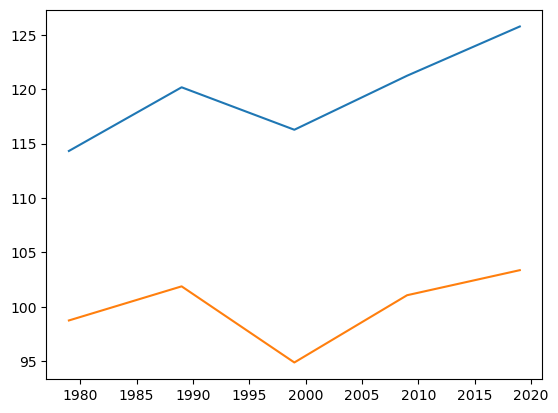

In [71]:
plt.plot(years, ortg_avg)
plt.plot(years, drtg_avg)

This graph shows that offensive and defensive rating are both increasing over time, with a dip in the 1990s. This may be confusing to some who are unfamiliar with the sport, however; as it seems to indicate that both offense and defense are improving. This is because, unlike most statistics, defensive rating is inverted - a higher defensive rating is actually worse.

I have laid out these two lines again below, but separately, with the y-axis for defensive rating flipped. This will give a more intuitive indication of how the two statistics have changed over time.

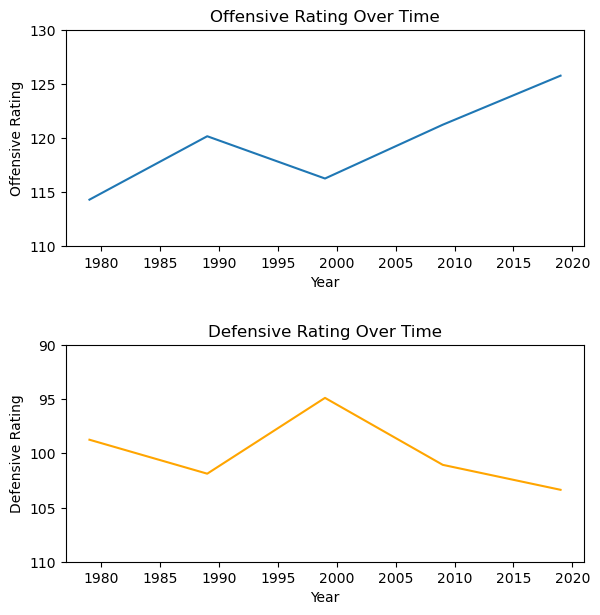

In [72]:
fig, axs = plt.subplots(2, figsize=(7,7))
fig.tight_layout(pad=5.0)
axs[0].plot(years, ortg_avg)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Offensive Rating')
axs[0].set_ylim(ymin=110)
axs[0].set_ylim(ymax=130)
axs[0].set_title('Offensive Rating Over Time')

axs[1].plot(years, drtg_avg, color='orange')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Defensive Rating')
axs[1].set_ylim(ymin=110)
axs[1].set_ylim(ymax=90)
axs[1].set_title('Defensive Rating Over Time')

plt.show()

Text(0.5, 1.0, 'Defensive Rebound Percentage Over Time')

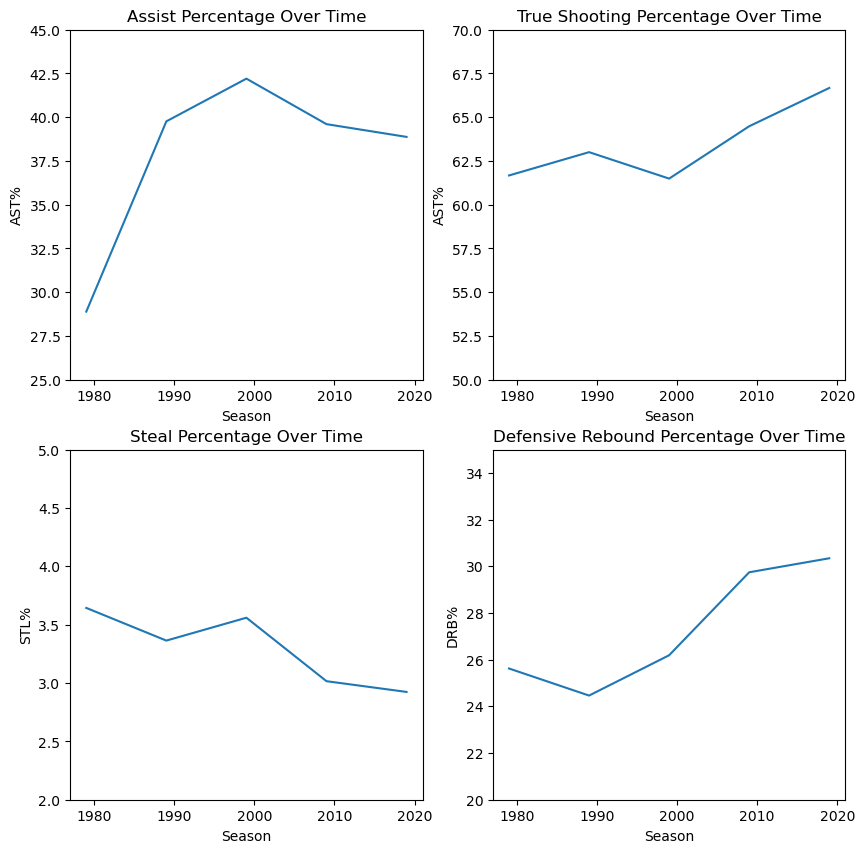

In [73]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

axs[0, 0].plot(years, astpct_avg)
axs[0, 0].set_ylim(ymin=25, ymax=45)
axs[0, 0].set_xlabel('Season')
axs[0, 0].set_ylabel('AST%')
axs[0, 0].set_title('Assist Percentage Over Time')

axs[0, 1].plot(years, tspct_avg)
axs[0, 1].set_ylim(ymin=50, ymax=70)
axs[0, 1].set_xlabel('Season')
axs[0, 1].set_ylabel('AST%')
axs[0, 1].set_title('True Shooting Percentage Over Time')

axs[1, 0].plot(years, stlpct_avg)
axs[1, 0].set_ylim(ymin=2, ymax=5)
axs[1, 0].set_xlabel('Season')
axs[1, 0].set_ylabel('STL%')
axs[1, 0].set_title("Steal Percentage Over Time")

axs[1, 1].plot(years, defrebpct_avg)
axs[1, 1].set_ylim(ymin=20, ymax=35)
axs[1, 1].set_xlabel('Season')
axs[1, 1].set_ylabel('DRB%')
axs[1, 1].set_title("Defensive Rebound Percentage Over Time")

## Correlation

The main purpose of these graphs is to get a general gauge of how these various statistics have changed over the years. Furthermore, they give us some good idea of what statistics might have a strong relationship. What I would now like to do is find which of our other 4 statistics are most heavily correlated with Offensive and Defensive rating. Obviously there are many statistics we have not considered, but the statistics I chose to measure are commonly considered good tells of how good a player's individual offense and defense is.

We will find the correlation of our Offensive and Defensive Rating stats with each of our other 4 statistics, to see which ones yield the strongest relationships. So in total we will find 8 correlation coefficients.

Correlation is measured from -1 to +1:

-Values close to zero indicate *little to no correlation.*

-Values closer to +1 indicate that the two variables are *positively correlated* - **higher** values of one generally correspond with **higher** values of the other. 

-Values closer to -1 indicate that the two variables are *negatively correlated* - **higher** values of one generally correspond with **lower** values of the other.

As an example, below we can see that Offensive Rating and True Shooting % have a correlation coefficient of 0.96, indicating that they have a very strong positive relationship. Higher values of one correlate very strongly with high values of the other.

In [75]:
corr_off_ts = np.corrcoef(ortg_avg, tspct_avg)
print(corr_off_ts[0][1])

0.9636927346249243


The remaining correlation coefficients follow below.

In [76]:
corr_off_ast = np.corrcoef(ortg_avg, astpct_avg)
corr_off_stl = np.corrcoef(ortg_avg, stlpct_avg)
corr_off_drb = np.corrcoef(ortg_avg, defrebpct_avg)

In [77]:
print(corr_off_ast[0][1])
print(corr_off_stl[0][1])
print(corr_off_drb[0][1])

0.4660403501909815
-0.9455789274832537
0.7205512714286896


From this, we can see that offensive rating has positive relationships with assists and rebounds, but not as strong as its relationship with TS%. However, what is notable to me is that offensive rating is very strongly *negatively* related to steals. And this makes sense - with fewer possessions ending in steals, that means the offense is turning the ball over less, and therefore they have more opportunities to score.

Now we will compute the correlation coefficients of defensive rating with our four statistics.

In [78]:
corr_def_ts = np.corrcoef(drtg_avg, tspct_avg)
corr_def_ast = np.corrcoef(drtg_avg, astpct_avg)
corr_def_stl = np.corrcoef(drtg_avg, stlpct_avg)
corr_def_drb = np.corrcoef(drtg_avg, defrebpct_avg)

In [79]:
print(corr_def_ts[0][1])
print(corr_def_ast[0][1])
print(corr_def_stl[0][1])
print(corr_def_drb[0][1])

0.8179012409027936
-0.030967114876447543
-0.7559179682352631
0.44240841596604336


As we can see here, defensive rating is most strongly correlated with true shooting percentage, and steals. Both of these make sense - as a higher defensive rating is actually worse, this means that higher TS% indicates worse (higher) defensive rating. This is intuitively sensible.

Furthermore, steals are often considered the best individual defense statistic, and so it is nice to see that lower (better) defensive rating is related to higher steal%.

## Diving Deeper

To recap - offensive rating (an estimate of how many points a player produces per 100 possessions) is most strongly correlated with True Shooting Percentage, which is an amalgamation of a player's ability to score that takes in all types of shots. As we can see, top-25 average TS% rose 5 percentage points from 1979 to 2019. In this section I will look to consider what may have caused that.

In [80]:
pleff_80 = pleff_20_min[pleff_20_min['year_id'] == 1980]

In [81]:
pleff_80_3pa = pleff_80.sort_values(by = '3PAr', ascending=False)
pleff_80_fta = pleff_80.sort_values(by = 'FTAr', ascending=False)
pleff_80_ts = pleff_80.sort_values(by = 'TS%', ascending=False)

pleff_89_3pa = pleff_89.sort_values(by = '3PAr', ascending=False)
pleff_89_fta = pleff_89.sort_values(by = 'FTAr', ascending=False)

pleff_99_3pa = pleff_99.sort_values(by = '3PAr', ascending=False)
pleff_99_fta = pleff_99.sort_values(by = 'FTAr', ascending=False)

pleff_09_3pa = pleff_09.sort_values(by = '3PAr', ascending=False)
pleff_09_fta = pleff_09.sort_values(by = 'FTAr', ascending=False)

pleff_19_3pa = pleff_19.sort_values(by = '3PAr', ascending=False)
pleff_19_fta = pleff_19.sort_values(by = 'FTAr', ascending=False)

Above I have created some more tables from our seasonal data - this time sorting values by 3PAr and FTAr. Those statistics represent the proportion of a player's field goal attempts that were three-point attempts, and his ratio of free throw attempts to field goal attempts, respectively. These statistics, I believe, will provide a valuable insight into the rise of TS% over the years, for the following reasons:

1) Three-point shots count the same as two-point shots in the denominator for TS%, but a successful one counts for an extra point in the numerator.

2) Free throws only count as 0.44 of a shot in the context of TS%. Since free throws are normally taken 2 or 3 at a time, making both would count for 2 points but only as 0.88 of a shot, which makes it better for TS% than making a single two-point shot. However, 3 free throws is not as good as a three-point shot, because it will count for 1.32 shots. So sacrificing threes for free throws is not the right thing to do for TS% maximization.

Knowing these things, we will do the same thing for these two stats as we did for the originals: create top-25 lists for them, and then graph the averages over time - but in addition to testing their correlation with our rating stats, we will also correlate them with TS%.
 
Note: For this section I have had to create and use player tables from 1980 instead of 1979. This is because the three-point shot was not introduced until the 1980 season.

In [82]:
pleff_80_3pa_top_25 = pleff_80_3pa.head(25)
pleff_80_fta_top_25 = pleff_80_fta.head(25)
pleff_80_ts_top_25 = pleff_80_ts.head(25)

pleff_89_3pa_top_25 = pleff_89_3pa.head(25)
pleff_89_fta_top_25 = pleff_89_fta.head(25)

pleff_99_3pa_top_25 = pleff_99_3pa.head(25)
pleff_99_fta_top_25 = pleff_99_fta.head(25)

pleff_09_3pa_top_25 = pleff_09_3pa.head(25)
pleff_09_fta_top_25 = pleff_09_fta.head(25)

pleff_19_3pa_top_25 = pleff_19_3pa.head(25)
pleff_19_fta_top_25 = pleff_19_fta.head(25)

In [83]:
pleff_80_3pa_avg = pleff_80_3pa_top_25.mean(numeric_only=True)
pleff_80_fta_avg = pleff_80_fta_top_25.mean(numeric_only=True)

pleff_89_3pa_avg = pleff_89_3pa_top_25.mean(numeric_only=True)
pleff_89_fta_avg = pleff_89_fta_top_25.mean(numeric_only=True)

pleff_99_3pa_avg = pleff_99_3pa_top_25.mean(numeric_only=True)
pleff_99_fta_avg = pleff_99_fta_top_25.mean(numeric_only=True)

pleff_09_3pa_avg = pleff_09_3pa_top_25.mean(numeric_only=True)
pleff_09_fta_avg = pleff_09_fta_top_25.mean(numeric_only=True)

pleff_19_3pa_avg = pleff_19_3pa_top_25.mean(numeric_only=True)
pleff_19_fta_avg = pleff_19_fta_top_25.mean(numeric_only=True)

We will now create average lists for these stats, just like we did before.

In [84]:
thrpa_avg = [16.76, 36.972, 59.824, 59.708, 74.396]
fta_avg = [58.704, 66.7, 73.564, 65.912, 53.924]

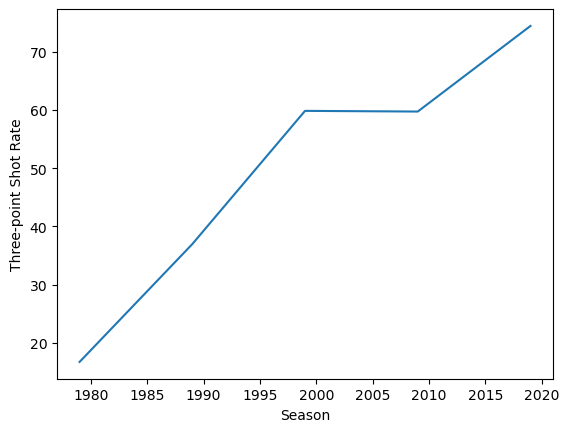

In [85]:
plt.plot(years, thrpa_avg)
plt.xlabel('Season')
plt.ylabel('Three-point Shot Rate')
plt.show()

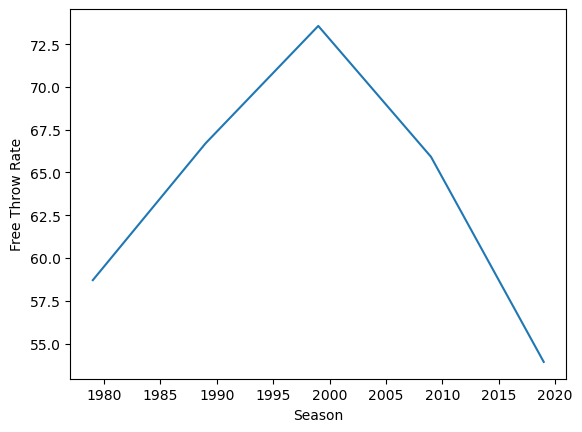

In [86]:
plt.plot(years, fta_avg)
plt.xlabel('Season')
plt.ylabel('Free Throw Rate')
plt.show()

As we can see, three-point shooting has rocketed dramatically over time, whereas free throw shooting peaked in the 1990s. This intuitively makes sense - shooting threes is significantly less likely to result in a foul than taking any other shot, and so a higher proportion of threes across the league will result in fewer free throws being taken.

As for why this is the case - a foul is called when a player makes illegal contact with another player - if the foul occurs while that player is shooting the ball, he will be awarded with free throws (2 if the shot was a two-point shot, 3 if it was a three-point shot. This is only the case when he misses the basket, however - If he makes the basket, he instead is awarded 1 free throw regardless of the shot type).

A player is much more likely to be fouled (contacted illegally) when he is driving to the basket for a close shot, rather than shooting a jump shot. As such, three-pointers are less often rewarded with fouls. Therefore, it makes sense that taking more threes will lead to fewer free throws.

### Correlation II

As I said above, we are now going to correlate our new stats with offensive and defensive rating, as well as true shooting %. This will give us a further idea of what may be driving what.

In [87]:
corr_off_3pa = np.corrcoef(ortg_avg, thrpa_avg)
corr_off_fta = np.corrcoef(ortg_avg, fta_avg)
print(corr_off_3pa[0][1])
print(corr_off_fta[0][1])

0.7429917692649897
-0.45078856213176255


As we can see, offensive rating has a fairly strong positive correlation with three-point attempts, and a weaker negative correlation with free throw attempts.

In [88]:
corr_def_3pa = np.corrcoef(drtg_avg, thrpa_avg)
corr_def_fta = np.corrcoef(drtg_avg, fta_avg)
print(corr_def_3pa[0][1])
print(corr_def_fta[0][1])

0.1978502329177368
-0.6864782892668476


Meanwhile, defensive rating has little correlation with three-point attempts, and a fairly strong negative correlation with free throw attempts.

In [89]:
corr_ts_3pa = np.corrcoef(tspct_avg, thrpa_avg)
corr_ts_fta = np.corrcoef(tspct_avg, fta_avg)
print(corr_ts_3pa[0][1])
print(corr_ts_fta[0][1])

0.6856589746073697
-0.6235782823835953


Finally, true shooting (which is what this section is supposed to be concerned with above all else) has a fairly strong correlation with both three-point proportion (positive) and free throw rate (negative).

# Overall Correlation Results

Below is a comprehensive list of every correlation we found, from strongest to weakest.

**IMPORTANT NOTE: I WILL BE MANUALLY REVERSING THE SIGN OF ALL CORRELATION COEFFICIENTS INVOLVING DEFENSIVE RATING, AS IT IS THE ONLY STAT WHERE HIGHER IS WORSE. THIS WILL MEAN CORRELATION PROPERLY MEASURES "BETTER AND WORSE" AS OPPOSED TO SIMPLY "HIGHER AND LOWER".**

## Positive Correlation

1) Offensive Rating - True Shooting % (0.964)
2) Defensive Rating - Steal Rate (0.756)
3) Offensive Rating - Three-point Rate (0.743)
4) Offensive Rating - Defensive Rebound Rate (0.721)
5) Defensive Rating - Free Throw Rate (0.6865)
6) True Shooting % - Three-point Rate (0.6856)
7) Offensive Rating - Assist Rate (0.466)
8) Defensive Rating - Assist Rate (0.031)

## Negative Correlation

1) Offensive Rating - Steal Rate (-0.946)
2) Defenive Rating - True Shooting (-0.818)
3) True Shooting - Free Throw Rate (-0.624)
4) Offensive Rating - Free Throw Rate (-0.451)
5) Defensive Rating - Defensive Rebound Rate (-0.442)
6) Defensive Rating - Three-point Rate (-0.198)

# Conclusion

Overall, it's impossible to truly say what has sparked the offensive surge of the modern NBA, but there are clearly patterns that arise when you track how offensive and defensive statistics have changed over the years. The ones that stand out the most to me are the following:

1) Offensive Rating is highly correlated with True Shooting %, which in turn has a strong correlation with Three-point Rate.
2) Every correlation coefficient involving True Shooting % is above (+ or -) 0.6, indicating that TS% is a sound statistic that gives a strong indication of others, in one direction or the other.
3) Free Throw Rate does not generally seem to be an indicator of better offense - this is counter to what I would have expected initially, but upon further thought makes some sense, as generally more free throws means one is not taking as many threes, due to the fact that free throws are more likely when one is closer to the basket.
4) Steals are very important to defense. Steals are positively related to better (lower) defensive rating, and very strongly negatively related to worse offensive rating.

In general, I think the logical conclusion is that higher offensive output is being driven by True Shooting % (Which is related to taking higher-quality shots, including more threes and fewer twos), and decline of steal numbers, which are vital to a defense's ability to prevent points.